In [1]:
import logging
import json
import torch
from types import SimpleNamespace
from vilbert.vilbert import VILBertActionGrounding, BertConfig
from pytorch_transformers.tokenization_bert import BertTokenizer
from pytorch_transformers.optimization import AdamW, WarmupLinearSchedule
import torch.distributed as dist
from VLN_config import config as args

In [15]:
import sys
import os
import torch
import yaml

import numpy as np
import matplotlib.pyplot as plt
import PIL

from PIL import Image
import cv2
import argparse
import glob
import pdb

import torchvision.models as models
import torchvision.transforms as transforms

from faster_rcnn import feature_extractor_new as f_extractor
from faster_rcnn.feature_extractor_new import featureExtractor
#%matplotlib inline  

In [16]:
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)
logger = logging.getLogger(__name__)
print(args)

namespace(adam_epsilon=1e-08, baseline=False, bert_model='bert-base-uncased', best_features=10, clean_train_sets=True, config_file='config/bert_base_6layer_6conect.json', distributed=False, do_lower_case=True, dynamic_attention=False, from_pretrained='save/multitask_model/multi_task_model.bin', gradient_accumulation_steps=1, img_weight=1, in_memory=False, learning_rate=0.0001, local_rank=-1, max_temporal_memory_buffer=5, mean_layer=True, num_train_epochs=10.0, num_workers=0, objective=1, predict_feature=False, save_name='', seed=42, split='mteval', start_epoch=0, task_specific_tokens=True, tasks='1', threshold_similarity=0.65, track_temporal_features=False, train_batch_size=1, visual_target=0, warmup_proportion=0.1, without_coattention=False)


In [17]:
# Input:
# - instruction.
# - image.

# train_dataset =
# val_dataset =


In [18]:
config = BertConfig.from_json_file(args.config_file)
bert_weight_name = json.load(
    open("config/" + args.bert_model + "_weight_name.json", "r")
)

tokenizer = BertTokenizer.from_pretrained(
    args.bert_model, do_lower_case=args.do_lower_case
)

config.track_temporal_features = args.track_temporal_features
config.mean_layer = args.mean_layer
config.max_temporal_memory_buffer = args.max_temporal_memory_buffer


model = VILBertActionGrounding.from_pretrained(
    args.from_pretrained, config=config, default_gpu=True
)

07/16/2020 18:06:10 - INFO - pytorch_transformers.tokenization_utils -   loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/mikel/.cache/torch/pytorch_transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
07/16/2020 18:06:10 - INFO - vilbert.utils -   loading weights file save/multitask_model/multi_task_model.bin
07/16/2020 18:06:14 - INFO - vilbert.utils -   Weights of VILBertActionGrounding not initialized from pretrained model: ['positional_enc.weight', 'positional_enc.bias', 'img_emb_mean.weight', 'img_emb_mean.bias', 'action_cls.predictions.bias', 'action_cls.predictions.transform.dense.weight', 'action_cls.predictions.transform.dense.bias', 'action_cls.predictions.transform.LayerNorm.weight', 'action_cls.predictions.transform.LayerNorm.bias', 'action_cls.predictions.decoder.weight', 'action_cls.bi_seq_relationship.weight', 'action_

In [19]:
model

VILBertActionGrounding(
  (positional_enc): Linear(in_features=6, out_features=2048, bias=True)
  (img_emb_mean): Linear(in_features=10240, out_features=2048, bias=True)
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (v_embeddings): BertImageEmbeddings(
      (image_embeddings): Linear(in_features=2048, out_features=1024, bias=True)
      (image_location_embeddings): Linear(in_features=5, out_features=1024, bias=True)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True

In [20]:
for key, value in dict(model.named_parameters()).items():
    if not value.requires_grad:
        print("This parameter does have grad", key)

In [21]:
model.eval()
cuda = torch.cuda.is_available()
if cuda: model = model.cuda(0)
#Why do we initialize Tokenizer again?
tokenizer = BertTokenizer.from_pretrained(
    args.bert_model, do_lower_case=args.do_lower_case
)

07/16/2020 18:06:16 - INFO - pytorch_transformers.tokenization_utils -   loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/mikel/.cache/torch/pytorch_transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


## Data preparation

In [22]:
def bert_tokenize( text):
    text = '[CLS]' + text + '[SEP]'
    tokenized_text = tokenizer.tokenize(text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    return indexed_tokens

In [ ]:
def mask_for_pretask(token):
    masked_lm_labels

In [23]:
text = "swimming elephant"
indexed_tokens = bert_tokenize(text)
print(indexed_tokens)

print(text)
query = '[CLS]' + text + '[SEP]'
tokens = tokenizer.encode(query)
print(tokens)

[101, 5742, 10777, 102]
swimming elephant
[101, 5742, 10777, 102]


In [24]:
def prediction(question, features, spatials, segment_ids, input_mask, image_mask, co_attention_mask, task_tokens, ):
    print('input question size question: ', question.shape)
    pos_enc_input = torch.FloatTensor([0,1,2,3,4,5])
    masked_lm_loss, masked_img_loss, prediction_t, prediction_v, all_attention_mask = model(
        input_ids=question, image_feat=features, image_loc=spatials,image_pos_input=pos_enc_input, output_all_attention_masks=True
    )
    return masked_lm_loss, masked_img_loss, prediction_t, prediction_v, all_attention_mask

In [27]:
def custom_prediction(query, task, features, infos):

#     print(query)
#     query = '[CLS]' + query + '[SEP]'
#     tokens = tokenizer.encode(query)
#     print(tokens)
    #tokens= 
    #tokens = tokenizer.add_special_tokens_single_sentence(tokens)
    
    tokens = bert_tokenize(query)
    segment_ids = [0] * len(tokens)
    input_mask = [1] * len(tokens)

    max_length = 37
    if len(tokens) < max_length:
        # Note here we pad in front of the sentence
        padding = [0] * (max_length - len(tokens))
        tokens = tokens + padding
        input_mask += padding
        segment_ids += padding

    text = torch.from_numpy(np.array(tokens)).cuda().unsqueeze(0)
    input_mask = torch.from_numpy(np.array(input_mask)).cuda().unsqueeze(0)
    segment_ids = torch.from_numpy(np.array(segment_ids)).cuda().unsqueeze(0)
    task = torch.from_numpy(np.array(task)).cuda().unsqueeze(0)

    num_image = len(infos)

    feature_list = []
    image_location_list = []
    image_mask_list = []
    for i in range(num_image):
        image_w = infos[i]['image_width']
        image_h = infos[i]['image_height']
        feature = features[i]
        num_boxes = feature.shape[0] #first dim size = number boxes

        g_feat = torch.sum(feature, dim=0) / num_boxes # Mean of features of all the selected regions
        num_boxes = num_boxes + 1
        feature = torch.cat([g_feat.view(1,-1), feature], dim=0)
        boxes = infos[i]['bbox']
        image_location = np.zeros((boxes.shape[0], 5), dtype=np.float32)
        image_location[:,:4] = boxes
        image_location[:,4] = (image_location[:,3] - image_location[:,1]) * (image_location[:,2] - image_location[:,0]) / (float(image_w) * float(image_h))
        image_location[:,0] = image_location[:,0] / float(image_w)
        image_location[:,1] = image_location[:,1] / float(image_h)
        image_location[:,2] = image_location[:,2] / float(image_w)
        image_location[:,3] = image_location[:,3] / float(image_h)
        g_location = np.array([0,0,1,1,1])
        image_location = np.concatenate([np.expand_dims(g_location, axis=0), image_location], axis=0)
        image_mask = [1] * (int(num_boxes))

        feature_list.append(feature)
        image_location_list.append(torch.tensor(image_location))
        image_mask_list.append(torch.tensor(image_mask))

    features = torch.stack(feature_list, dim=0).float().cuda()
    spatials = torch.stack(image_location_list, dim=0).float().cuda()
    image_mask = torch.stack(image_mask_list, dim=0).byte().cuda()
    co_attention_mask = torch.zeros((num_image, num_boxes, max_length)).cuda()
    print("text: ", text)
    print("feat: ", features)
    print("spatials: ", spatials)
    print("segments_id: ", segment_ids)
    print("input_mask: ", input_mask)
    print("image_mask: ", image_mask)
    print("coatenttion_mask: ", co_attention_mask)
    return prediction(text, features, spatials, segment_ids, input_mask, image_mask, co_attention_mask, task)

#############current image:  1 #############
len self.embedding_rois:  1 shape first elt:  torch.Size([10, 2048])
-----Before----->  deque([])
-----New----->  tensor([[ 0.3596,  2.2978,  1.7182,  ...,  0.0202, -1.4731, -1.9730],
        [-0.1729,  3.0453, -1.7941,  ..., -1.5926, -3.3911, -1.3847],
        [ 0.9536, -0.5389, -0.5606,  ..., -1.2014,  1.1629, -0.0176],
        ...,
        [-0.0941, -0.0294, -0.2801,  ...,  0.1063,  0.6063,  0.0495],
        [ 1.0415,  2.3711, -0.2841,  ..., -1.0708, -0.5086, -1.0113],
        [-0.0985,  1.3032, -0.4412,  ..., -1.5207,  0.5634, -0.3943]])
-----After------>  deque([])
-----After temp------>  deque([])
features:  <class 'list'>
infos:  [{'bbox': array([[249.14554 , 118.5359  , 606.18854 , 426.94788 ],
       [393.7834  , 303.3425  , 510.82028 , 421.05118 ],
       [ 14.686959, 280.43024 , 278.091   , 441.1726  ],
       [196.92993 , 378.21988 , 452.6046  , 436.02533 ],
       [ 31.044245, 340.09845 , 440.56097 , 439.95114 ],
       [364.301

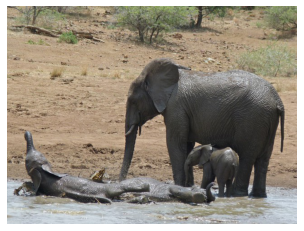

text:  tensor([[  101,  5742, 10777,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], device='cuda:0')
feat:  tensor([[[ 0.3437,  1.3727, -0.4166,  ..., -0.9121, -0.2867, -0.3962],
         [ 0.3596,  2.2978,  1.7182,  ...,  0.0202, -1.4731, -1.9730],
         [-0.1729,  3.0453, -1.7941,  ..., -1.5926, -3.3911, -1.3847],
         ...,
         [-0.0941, -0.0294, -0.2801,  ...,  0.1063,  0.6063,  0.0495],
         [ 1.0415,  2.3711, -0.2841,  ..., -1.0708, -0.5086, -1.0113],
         [-0.0985,  1.3032, -0.4412,  ..., -1.5207,  0.5634, -0.3943]]],
       device='cuda:0')
spatials:  tensor([[[0.0000, 0.0000, 1.0000, 1.0000, 1.0000],
         [0.3893, 0.2469, 0.9472, 0.8895, 0.3585],
         [0.6153, 0.6320, 0.7982, 0.8772, 0.0448],
         [0.0229, 0.5842, 0.4345, 0.9191, 

In [28]:
frcnn_model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# read image 
#pic = "faster_rcnn/test2.png"
#pic1 = "faster_rcnn/test.png"
#image_paths = [pic, pic1]



image_path = ['demo/1.jpg']
features, infos = featureExtractor(image_path, frcnn_model).extract_features()
print("features: ", type(features))
print("infos: ", infos)
#features, infos = f_extractor.extract_features(image_path, frcnn_model)


img = PIL.Image.open(image_path[0]).convert('RGB')
img = torch.tensor(np.array(img))

plt.axis('off')
plt.imshow(img)
plt.show()
    
query = "swimming elephant"
task = [9]
masked_lm_loss, masked_img_loss, prediction_t, prediction_v, all_attention_mask = custom_prediction(query, task, features, infos)

In [ ]:
print(features[0].shape)
for k, v in infos[0].items():
    print(k)
    print(v)

In [ ]:
masked_lm_loss

In [ ]:
 prediction_t.shape

In [ ]:
prediction_t

In [ ]:
prediction_v.shape

In [ ]:
prediction_v

In [ ]:
all_attention_mask

In [ ]:
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
config.visual_target = args.visual_target

optimizer_grouped_parameters = []
for key, value in dict(model.named_parameters()).items():
    if value.requires_grad:
        if "cls" in key:
            lr = args.learning_rate
        else:
            lr = args.learning_rate * 0.1
        if any(nd in key for nd in no_decay): # No decay
            optimizer_grouped_parameters += [
                {"params": [value],
                 "lr": lr,
                 "weight_decay": 0.0}
            ]
        
        elif not any(nd in key for nd in no_decay):
            optimizer_grouped_parameters += [
                {"params": [value],
                 "lr": lr,
                 "weight_decay": 0.01}
            ]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=args.learning_rate,
    eps=args.adam_epsilon,
    betas=(0.9, 0.98),
)

num_dataset_points = 19

num_train_optimization_steps = int(
    num_dataset_points
    / args.train_batch_size
    / args.gradient_accumulation_steps
) * (args.num_train_epochs - args.start_epoch)

scheduler = WarmupLinearSchedule(
    optimizer,
    warmup_steps=args.warmup_proportion * num_train_optimization_steps,
    t_total=num_train_optimization_steps,
)

In [ ]:
# model.cuda()
# for state in optimizer.state.values():
#     for k, v in state.items():
#         if torch.is_tensor(v):
#             state[k] = v.cuda()

logger.info("***** Running training *****")
logger.info("Num examples = %d", num_dataset_points)
logger.info("Batch size = %d", args.train_batch_size)
logger.info("Num steps = %d", num_train_optimization_steps)

In [ ]:
model

In [ ]:
startIterID = 0
global_step = 0

for epoch in range(int(args.start_epoch), int(args.num_train_epochs)):
    model.train()
    for step, batch in enumerate(train_dataset):
        iterId = startIterID + step + (epochId * len(train_dataset))
    